# **Yüz Maskesi Tespiti İçin Derin Öğrenme Modeli**

In [1]:
# Gerekli kütüphaneleri yükleme
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

## **Veri Setini Yükleme ve Açma**

In [7]:
import os

zip_path = "/content/archive.zip"
extract_path = "/content/face-mask-dataset/"

os.system(f"unzip {zip_path} -d {extract_path}")

# 'data' klasörünün alt klasörlerini listele
data_path = os.path.join(extract_path, "data")
categories = os.listdir(data_path)
print("Kategoriler:", categories)

# Her kategorideki görüntü sayısını kontrol etme
for category in categories:
    category_path = os.path.join(data_path, category)
    print(f"{category}: {len(os.listdir(category_path))} görüntü")


Kategoriler: ['with_mask', 'without_mask']
with_mask: 3725 görüntü
without_mask: 3828 görüntü


## **Görüntü Yollarını ve Etiketlerini Hazırlama**


In [8]:
# Görüntü yollarını ve etiketlerini oluşturma
image_paths = []
labels = []
for idx, category in enumerate(categories):
    category_path = os.path.join(data_path, category)
    for img_path in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_path))
        labels.append(idx)


## **Veriyi Eğitim ve Test Olarak Ayırma**


In [9]:
# %80 eğitim, %20 test olarak ayırma
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Eğitim ve validasyon olarak ayırma
train_X, val_X, train_Y, val_Y = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)


## **Veri Artırımı ve Data Generator Oluşturma**


In [10]:
# Veri artırımı
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
train_generator = datagen.flow_from_directory(data_path, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_generator = datagen.flow_from_directory(data_path, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')


Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.


## **Modeli Oluşturma**


In [11]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Base model ağırlıklarını dondurma
for layer in base_model.layers:
    layer.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Modeli Derleme**


In [12]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Eğitim adımlarını hesaplama
steps_per_epoch = len(train_X) // batch_size
validation_steps = len(val_X) // batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)


Steps per epoch: 151
Validation steps: 37


## **Callback Fonksiyonları ve Model Eğitimi**


In [13]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

epoch_learning = 100

history = model.fit(
    train_generator,
    epochs=epoch_learning,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/151 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.7619 - loss: 0.4608

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 110s 512ms/step - accuracy: 0.7757 - loss: 0.4393 - val_accuracy: 0.9831 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 2/100
 84/151 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.9630 - loss: 0.0961

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 308ms/step - accuracy: 0.9642 - loss: 0.0909 - val_accuracy: 0.9873 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - accuracy: 0.9721 - loss: 0.0715 - val_accuracy: 0.9899 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.9719 - loss: 0.0805 - val_accuracy: 0.9916 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 393ms/step - accuracy: 0.9694 - loss: 0.0763 - val_accuracy: 0.9941 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.9782 - loss: 0.0689 - val_accuracy: 0.9932 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 59s 376ms/step - accuracy: 0.9718 - loss: 0.0787 - val_accuracy: 0.9955 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9760 -

## **Eğitim ve Validasyon Sonuçlarının Görselleştirilmesi**


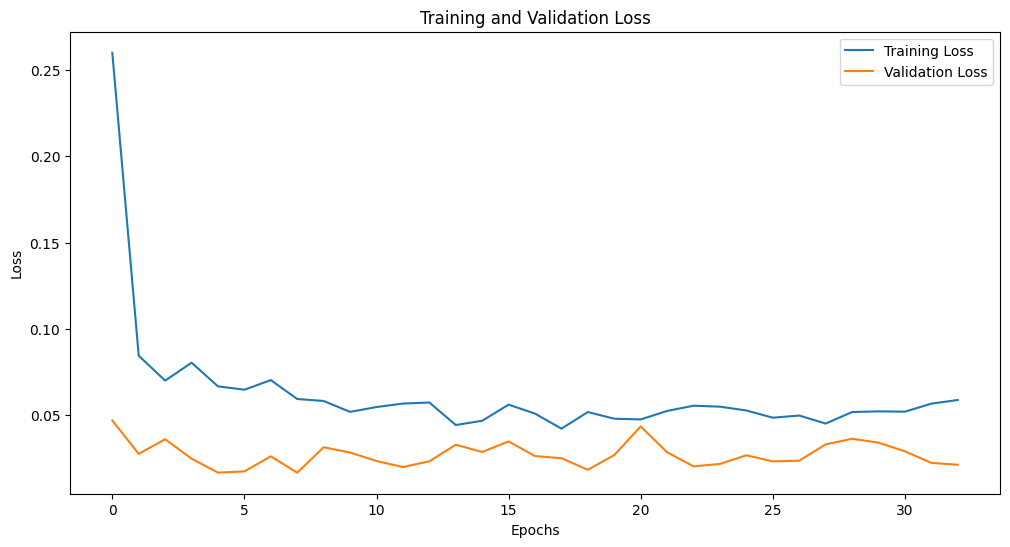

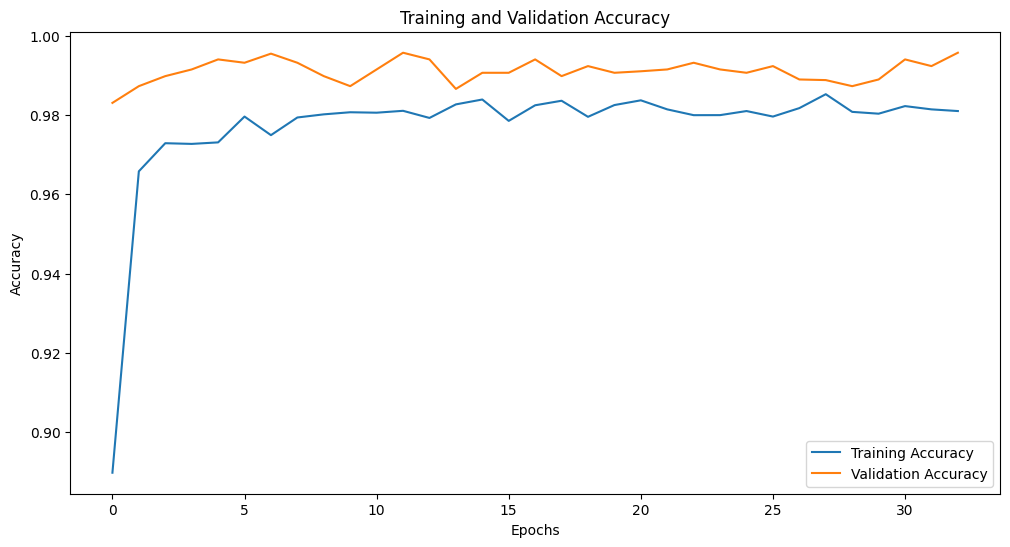

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## **Fine-Tuning Süreci**


In [15]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epoch_ft = 50

model.fit(
    train_generator,
    epochs=epoch_ft,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

model.load_weights('best_model.keras')


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 108s 487ms/step - accuracy: 0.9608 - loss: 0.1050 - val_accuracy: 0.9941 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 48s 323ms/step - accuracy: 0.9655 - loss: 0.0971 - val_accuracy: 0.9882 - val_loss: 0.0352 - learning_rate: 1.0000e-04
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 411ms/step - accuracy: 0.9666 - loss: 0.0846 - val_accuracy: 0.9865 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9683 - loss: 0.0898 - val_accuracy: 0.9882 - val_loss: 0.0323 - learning_rate: 1.0000e-04
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 389ms/step - accuracy: 0.9728 - loss: 0.0767 - val_accuracy: 0.9975 - val_loss: 0.0123 - learning_rate: 1.0000e-04
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.9655 - loss: 0.0856 - val_accuracy: 0.9924 - val_loss: 0.0270 - learning_rate: 1.0000e-04
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 58s 3

## **Model Değerlendirme ve Performans Analizi**


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Confusion Matrix:
 [[14  0]
 [ 0 18]]
True Negatives (TN): 14
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 18
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00, , Specificity: 1.00


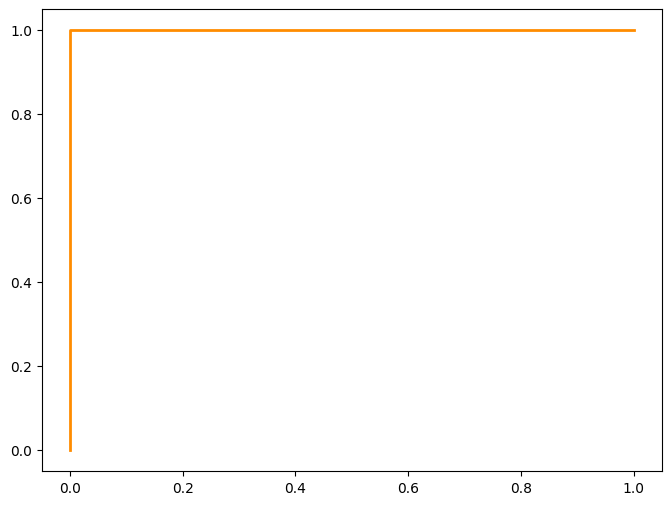

In [19]:
test_images_array, test_labels_array = next(val_generator)
y_pred = model.predict(test_images_array)
y_pred_classes = y_pred.argmax(axis=1)

accuracy = accuracy_score(test_labels_array.argmax(axis=1), y_pred_classes)
precision = precision_score(test_labels_array.argmax(axis=1), y_pred_classes, average='weighted')
recall = recall_score(test_labels_array.argmax(axis=1), y_pred_classes, average='weighted')
f1 = f1_score(test_labels_array.argmax(axis=1), y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(test_labels_array.argmax(axis=1), y_pred_classes)
tn, fp, fn, tp = confusion_matrix(test_labels_array.argmax(axis=1), y_pred_classes).ravel()
specificity = tn / (tn + fp)

print("Confusion Matrix:\n", conf_matrix)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, , Specificity: {specificity:.2f}")
fpr, tpr, _ = roc_curve(test_labels_array.argmax(axis=1), y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')


## **Sonuçların Kaydedilmesi**


In [20]:
model.save('final_model.keras')